In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from calendar import monthrange
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import h5py

In [2]:
import pandas as pd

# Charger le dataset
file_path = 'sample.csv'
df = pd.read_csv(file_path)

# Afficher les premières lignes du dataset
df.head(), df.columns

(   Unnamed: 0  NUM_POSTE NOM_USUEL      LAT       LON  ALTI      AAAAMM  Year  \
 0      113156   28070001  CHARTRES  48.4605  1.501167   155  1950-01-01  1950   
 1      113157   28070001  CHARTRES  48.4605  1.501167   155  1950-02-01  1950   
 2      113158   28070001  CHARTRES  48.4605  1.501167   155  1950-03-01  1950   
 3      113159   28070001  CHARTRES  48.4605  1.501167   155  1950-04-01  1950   
 4      113160   28070001  CHARTRES  48.4605  1.501167   155  1950-05-01  1950   
 
    Month  precip_cumul_mensu  ...  vent_speed_inst_moy_mensu  \
 0      1                20.6  ...                       14.0   
 1      2                56.8  ...                       21.2   
 2      3                24.4  ...                       13.7   
 3      4                52.8  ...                       17.3   
 4      5                65.6  ...                       11.9   
 
    vent_speed_inst_max_mensu  vent_dir_inst  vent_nbjour_inst_speedsup10ms  \
 0                       54.0      

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Sélection des colonnes pertinentes pour la prédiction
columns_of_interest = ['AAAAMM', 'vent_speed_inst_moy_mensu', 'temp_mean_mensu',
                       'precip_cumul_mensu', 'humi_moy_mensu']

# Filtrer le dataset
df_filtered = df[columns_of_interest]

# Convertir la colonne 'AAAAMM' en format datetime
df_filtered['AAAAMM'] = pd.to_datetime(df_filtered['AAAAMM'], format='%Y-%m-%d')

# Supprimer les lignes avec des valeurs manquantes
df_filtered = df_filtered.dropna()

# Normaliser les données
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_filtered.drop(columns=['AAAAMM']))

# Afficher les premières lignes après la normalisation
df_filtered['vent_speed_inst_moy_mensu'] = df_scaled[:, 0]
df_filtered.head()


C:\Users\dsgat\AppData\Local\Temp\ipykernel_5568\2317399705.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['AAAAMM'] = pd.to_datetime(df_filtered['AAAAMM'], format='%Y-%m-%d')


,AAAAMM,vent_speed_inst_moy_mensu,temp_mean_mensu,precip_cumul_mensu,humi_moy_mensu
0,1950-01-01,0.409836,4.7,20.6,90.0
1,1950-02-01,0.803279,10.1,56.8,83.0
3,1950-04-01,0.590164,13.1,52.8,76.0
4,1950-05-01,0.295082,19.2,65.6,77.0
5,1950-06-01,0.158470,24.2,23.9,74.0


Modèle 6 :

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Attention, Add, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Préparer les données
X = df_scaled[:, 1:]
y = df_scaled[:, 0]
sequence_length = 48
batch_size = 1

# Créer le générateur de séquences temporelles
generator = TimeseriesGenerator(X, y, length=sequence_length, batch_size=batch_size)

# Construire le modèle
input_layer = Input(shape=(sequence_length, X.shape[1]))
lstm_layer = Bidirectional(LSTM(100, return_sequences=True, activation='relu'))(input_layer)
attention_scores = Attention()([lstm_layer, lstm_layer])
context_vector = Add()([attention_scores, lstm_layer])
flatten_layer = Flatten()(context_vector)
dropout_layer = Dropout(0.2)(flatten_layer)
output_layer = Dense(1)(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Compiler et entraîner le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(generator, epochs=100, verbose=1)

# Faire des prédictions
y_true = df_scaled[sequence_length:, 0]
y_pred = model.predict(generator)

# Inverser la normalisation
y_true_inverse = scaler.inverse_transform(np.concatenate((y_true.reshape(-1, 1), X[sequence_length:]), axis=1))[:, 0]
y_pred_inverse = scaler.inverse_transform(np.concatenate((y_pred, X[sequence_length:]), axis=1))[:, 0]

# Calculer les métriques
rmse = np.sqrt(mean_squared_error(y_true_inverse, y_pred_inverse))
mae = mean_absolute_error(y_true_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_true_inverse, y_pred_inverse)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

#sauvegarder le modèle
model.save('modelv6turbo.h5')
model.save_weights('modelv6turbo_weights.h5')
model.to_json('modelv6turbo.json')

Epoch 1/100
 23/682 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1245

c:\Users\dsgat\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


682/682 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0334
Epoch 2/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0145
Epoch 3/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0144
Epoch 4/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0141
Epoch 5/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0152
Epoch 6/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0127
Epoch 7/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0129
Epoch 8/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0118
Epoch 9/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0127
Epoch 10/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0101
Epoch 11/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0100
Epoch 12/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0116
Epoch 13/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0110
Epoch 14/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0118
Epoch 15/100
682/682 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step -

In [21]:
model.save_weights('modelv6turbo_weights.weights.h5')

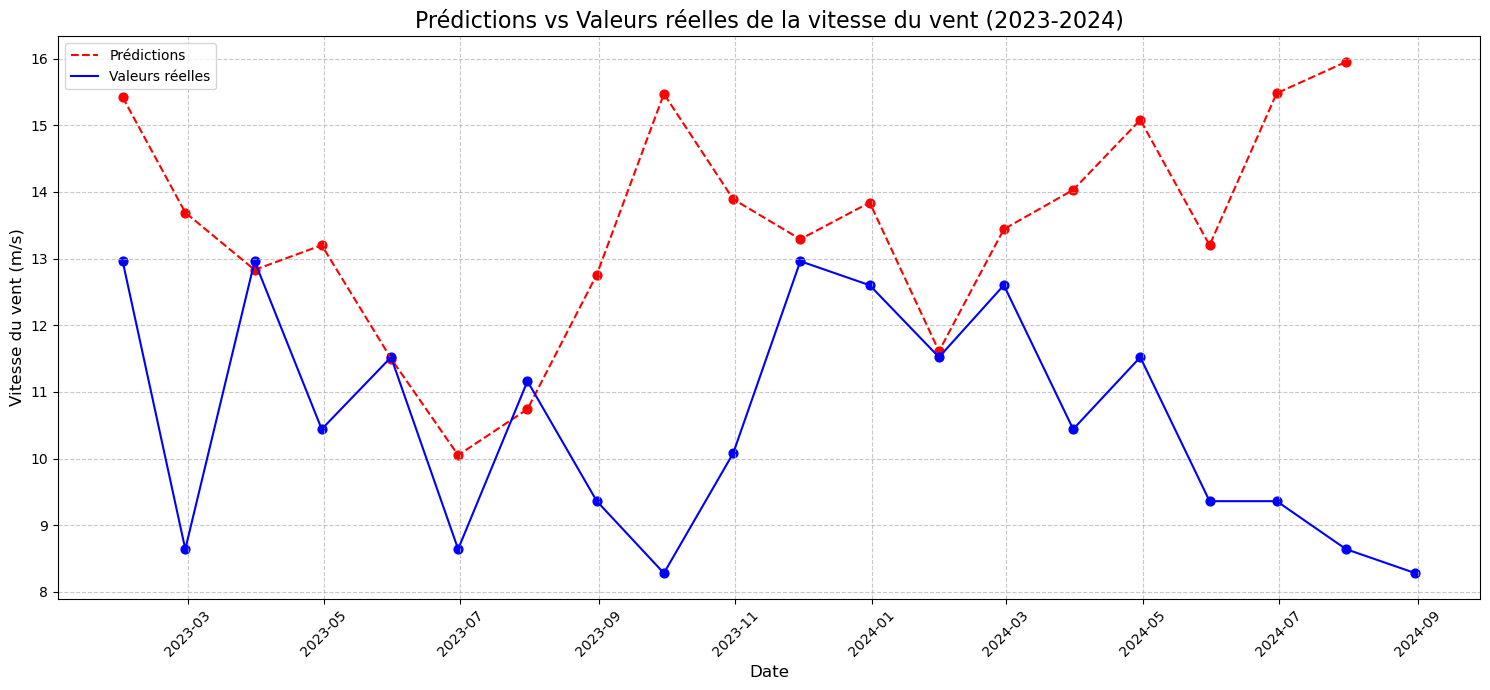

MAE: 2.82
RMSE: 3.65


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer un DataFrame pour les prédictions
predictions = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-31', end='2024-07-31', freq='ME'),
    'Predicted': []
})
predictions.set_index('Date', inplace=True)

# Créer un DataFrame pour les valeurs réelles
real_values = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-31', end='2024-08-31', freq='ME'),
    'Real': [12.96, 8.64, 12.96, 10.44, 11.52, 8.64, 11.16, 9.36, 8.28, 10.08, 12.96, 12.60,
             11.52, 12.60, 10.44, 11.52, 9.36, 9.36, 8.64, 8.28]
})
real_values.set_index('Date', inplace=True)

# Créer le graphique
plt.figure(figsize=(15, 7))

# Tracer les prédictions
plt.plot(predictions.index, predictions['Predicted'], 'r--', label='Prédictions')
plt.scatter(predictions.index, predictions['Predicted'], color='red', s=40)

# Tracer les valeurs réelles
plt.plot(real_values.index, real_values['Real'], 'b-', label='Valeurs réelles')
plt.scatter(real_values.index, real_values['Real'], color='blue', s=40)

# Personnaliser le graphique
plt.title('Prédictions vs Valeurs réelles de la vitesse du vent (2023-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Vitesse du vent (m/s)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45)

# Ajuster automatiquement la mise en page
plt.tight_layout()

# Afficher le graphique
plt.show()

# Calculer et afficher les métriques d'erreur
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(real_values['Real'][:19], predictions['Predicted'])
rmse = np.sqrt(mean_squared_error(real_values['Real'][:19], predictions['Predicted']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer un DataFrame pour les prédictions
predictions = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-31', end='2024-07-31', freq='ME'),
    'Predicted': [  remplacer par valeurs prédites]
})
predictions.set_index('Date', inplace=True)

# Créer un DataFrame pour les valeurs réelles
real_values = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-31', end='2024-08-31', freq='ME'),
    'Real': [12.96, 8.64, 12.96, 10.44, 11.52, 8.64, 11.16, 9.36, 8.28, 10.08, 12.96, 12.60,
             11.52, 12.60, 10.44, 11.52, 9.36, 9.36, 8.64, 8.28]
})
real_values.set_index('Date', inplace=True)

# Créer le graphique
plt.figure(figsize=(15, 7))

# Tracer les prédictions
plt.plot(predictions.index, predictions['Predicted'], 'r--', label='Prédictions')
plt.scatter(predictions.index, predictions['Predicted'], color='red', s=40)

# Tracer les valeurs réelles
plt.plot(real_values.index, real_values['Real'], 'b-', label='Valeurs réelles')
plt.scatter(real_values.index, real_values['Real'], color='blue', s=40)

# Personnaliser le graphique
plt.title('Prédictions vs Valeurs réelles de la vitesse du vent (2023-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Vitesse du vent (m/s)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45)

# Ajuster automatiquement la mise en page
plt.tight_layout()

# Afficher le graphique
plt.show()

# Calculer et afficher les métriques d'erreur
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(real_values['Real'][:19], predictions['Predicted'])
rmse = np.sqrt(mean_squared_error(real_values['Real'][:19], predictions['Predicted']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")